In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

In [14]:
df = pd.read_csv(r"C:\Users\Dhruv\Downloads\AAI\Assignments\diabetes.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [5]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## Visualization of Raw Data

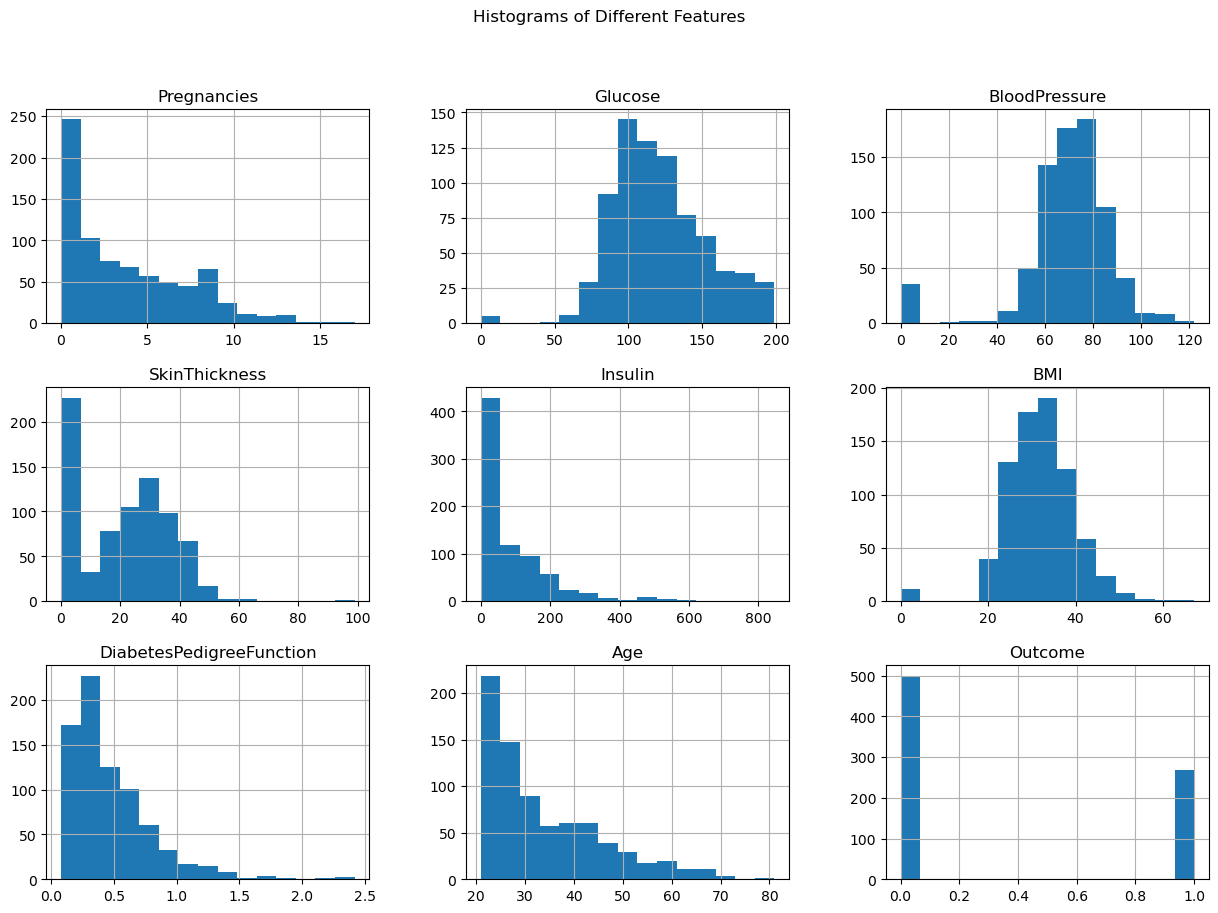

In [6]:
df.hist(bins=15, figsize=(15, 10), layout=(3, 3))
plt.suptitle('Histograms of Different Features')
plt.show()

##### Pregnancies, Insulin, DiabetesPedigreeFunction, Age have Logarithmic Distribution

##### Glucose, Blood Pressure, Skin Thickness, BMI have Normal Distribution

## Transforming Logarithmic Data

##### Since all the logarithmic distributed data is right skewed, we can apply logarithm transformation

In [15]:
columns_to_transform = ["Pregnancies", "Insulin", "DiabetesPedigreeFunction", "Age"]
epsilon = 1e-9

# Replace non-positive values with the small constant so that log transformation doesn't give -inf for non-positive values
df[columns_to_transform] = df[columns_to_transform].map(lambda x: x if x > 0 else epsilon)

df[columns_to_transform] = df[columns_to_transform].apply(np.log)

## Removing Irrelevant Data

In [16]:
zero_counts = df.apply(lambda column: (column == 0).sum())

print(zero_counts)

Pregnancies                 135
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                       0
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64


##### Since Glucose, BloodPressure and Insulin cannot be zero in any case these values can either be removed or imputed

##### Skin Thickness may be zero due to normalization of decimal values

In [17]:
columns_with_zeros = ['Glucose', 'BloodPressure', 'BMI']
df[columns_with_zeros] = df[columns_with_zeros].replace(0, np.nan)

In [18]:
df.dropna(inplace=True)

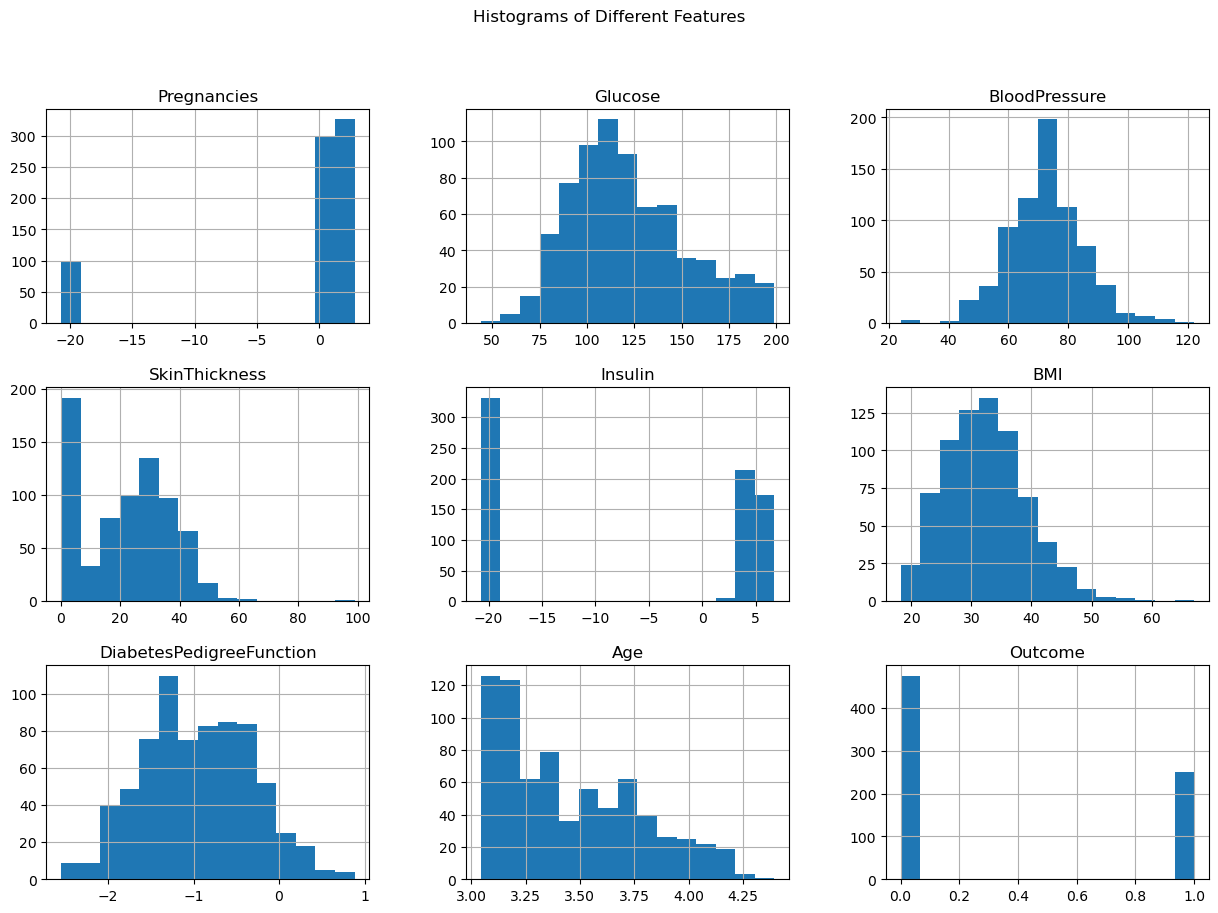

In [19]:
df.hist(bins=15, figsize=(15, 10), layout=(3, 3))
plt.suptitle('Histograms of Different Features')
plt.show()

## Removing Outliers

In [20]:
def remove_outliers_zscore(df, threshold=3):
    df_cleaned = df.copy()
    
    for col in df_cleaned.columns[:-1]:
        z_scores = np.abs(stats.zscore(df_cleaned[col]))
        df_cleaned = df_cleaned[z_scores < threshold]
    return df_cleaned

df_cleaned = remove_outliers_zscore(df)

## Removing Features with High Correlation

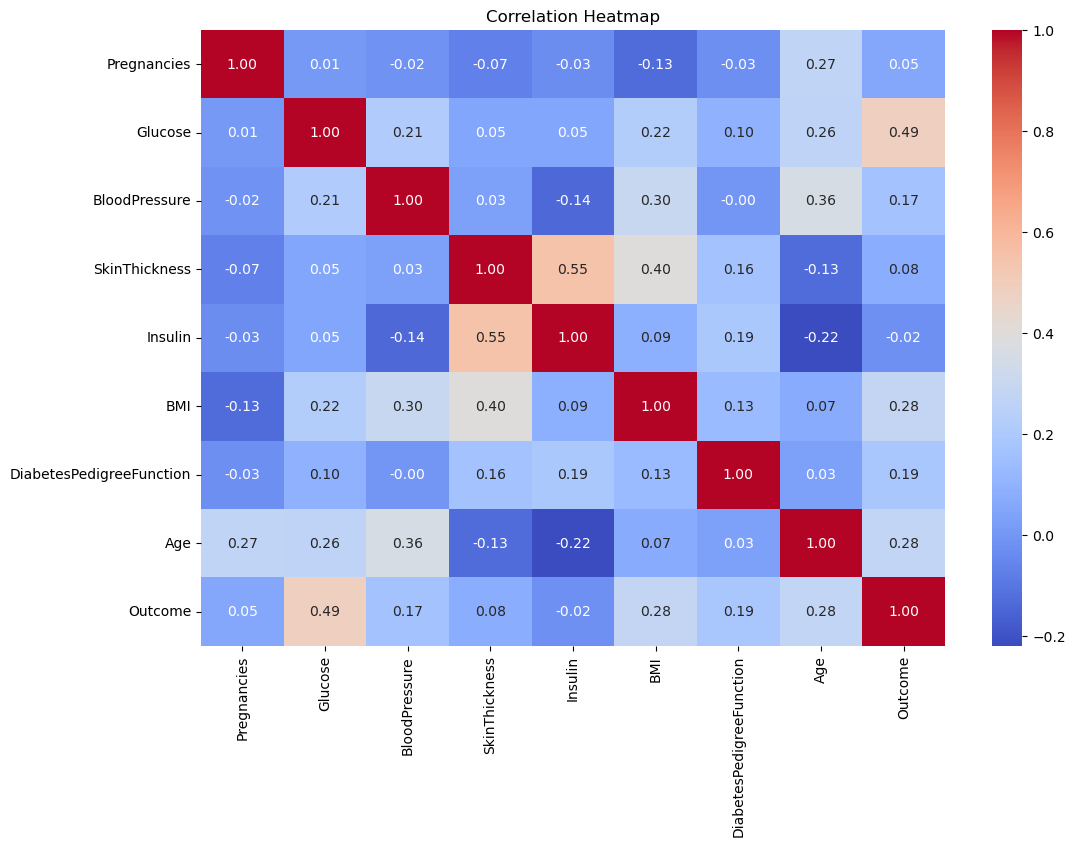

In [21]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_cleaned.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

##### No high correlation among the features

## Visualization of Cleaned Data

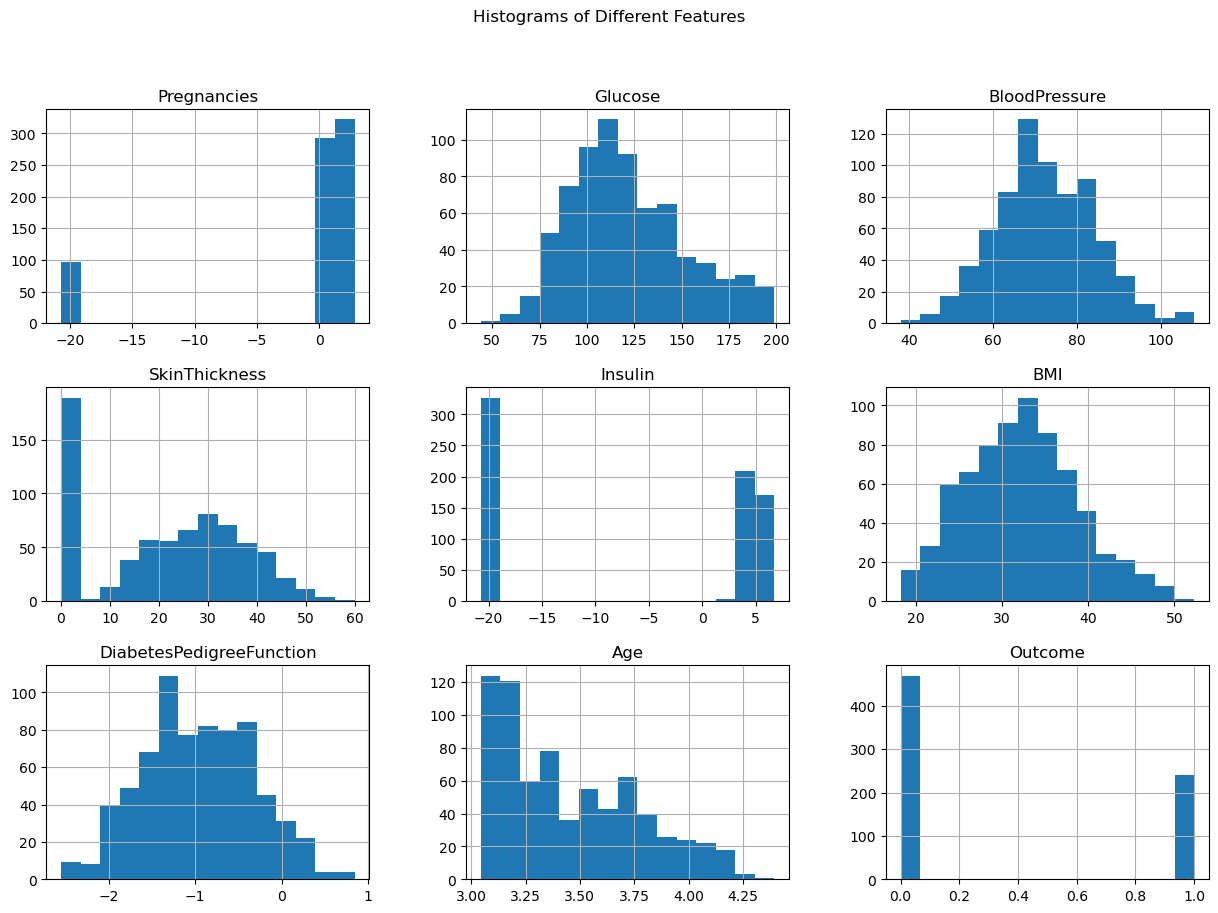

In [22]:
df_cleaned.hist(bins=15, figsize=(15, 10), layout=(3, 3))
plt.suptitle('Histograms of Different Features')
plt.show()

## Transforming Columns with Logarithmic Distribution back to their Original Value

In [15]:
df_cleaned[columns_to_transform] = np.exp(df_cleaned[columns_to_transform])

In [16]:
df_cleaned.to_csv("diabetes_cleaned.csv", index=False)

## Splitting Training and Testing Data

In [23]:
X_train, X_test, y_train, y_test = train_test_split(df_cleaned.drop('Outcome', axis=1), \
                                                    df_cleaned['Outcome'], test_size=0.2, random_state=42)

## Scaling the Training and Testing Data

In [24]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)

## Fitting and Predicting Decision Tree Model

In [47]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 20, 25, 30],
    'min_samples_leaf': [1, 2, 4, 6, 8, 10]
}

dt = DecisionTreeClassifier(random_state=42)

grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, 
                           cv=5, scoring='accuracy', 
                           n_jobs=-1, verbose=1)

grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 10, 20, 30, 40, 50],
                         'min_samples_leaf': [1, 2, 4, 6, 8, 10],
                         'min_samples_split': [2, 5, 10, 20, 25, 30]},
             scoring='accuracy', verbose=1)

In [48]:
print("Best Parameters:")
print(grid_search.best_params_)

print("Best Score:")
print(grid_search.best_score_)

Best Parameters:
{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 8, 'min_samples_split': 30}
Best Score:
0.7693681105418413


In [50]:
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

f1_score = classification_report(y_test, y_pred, output_dict=True)['weighted avg']['f1-score']
print(f'F1-score: {f1_score}')

Accuracy: 0.7132867132867133
F1-score: 0.7194680640183407


In [52]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.76      0.79       102
           1       0.50      0.59      0.54        41

    accuracy                           0.71       143
   macro avg       0.66      0.68      0.67       143
weighted avg       0.73      0.71      0.72       143



## Fitting and Predicting Random Forest Model

In [53]:
param_grid = {
    'n_estimators': [200, 300, 400, 500],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [3, 4, 5],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=5, scoring='accuracy', 
                           n_jobs=-1, verbose=1)

grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [3, 4, 5],
                         'n_estimators': [200, 300, 400, 500]},
             scoring='accuracy', verbose=1)

In [54]:
print("Best Parameters:")
print(grid_search.best_params_)

print("Best Score:")
print(grid_search.best_score_)

Best Parameters:
{'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Best Score:
0.7852507374631269


In [56]:
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

f1_score = classification_report(y_test, y_pred, output_dict=True)['weighted avg']['f1-score']
print(f'F1-score: {f1_score}')

Accuracy: 0.7132867132867133
F1-score: 0.7179236751234672


In [55]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.76      0.79       102
           1       0.50      0.59      0.54        41

    accuracy                           0.71       143
   macro avg       0.66      0.68      0.67       143
weighted avg       0.73      0.71      0.72       143



## Evaluation of Best Estimator

In [58]:
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

f1_score = classification_report(y_test, y_pred, output_dict=True)['weighted avg']['f1-score']
print(f'F1-score: {f1_score}')

Accuracy: 0.7132867132867133
F1-score: 0.7179236751234672


## Using Random Forest with Default Parameters

In [59]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

In [60]:
y_pred = rf.predict(X_test_scaled)

In [62]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

f1_score = classification_report(y_test, y_pred, output_dict=True)['weighted avg']['f1-score']
print(f'F1-score: {f1_score}')

Accuracy: 0.7342657342657343
F1-score: 0.7361137212622362


- Testing Accuracy is same for both Decision Tree and Random Forest (with GridSearch Parameters) i.e. 71% in both
- Testing Accuracy for Random Forest Model with default parameters is 73%

- F1 score is same for both Decision Tree and Random Forest (with GridSearch Parameters) i.e. 72 in both
- F1 score for Random Forest Model with default parameters is 74

##### Random Forest improves accuracy and F1 score by averaging multiple decision trees, reducing overfitting and capturing more complex patterns. 